<font size="+2" color="orange"><b>Introduction</b></font><br>

> This competition aims to identify a wide variety of bird vocalizations in soundscape recordings. The challenge would be to build a model which can separate/differentiate bird voices from other anthropogenic sounds (e.g., airplane overflights). The dataset provided in this competition is prepared by Cornell Lab of Ornithology’s Center for Conservation Bioacoustics (CCB)’s.The CCB develops innovative conservation technologies to inspire and inform the conservation of wildlife and habitats globally.Building an efficient solution will help researchers better understand changes in habitat quality, levels of pollution, and the effectiveness of restoration efforts

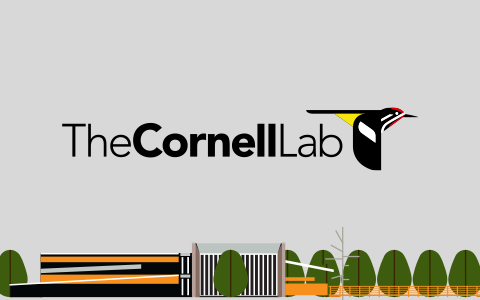

<font size="+2" color="green"><b>References of some other notebooks used in this project</b></font><br>

https://www.kaggle.com/andradaolteanu/birdcall-recognition-eda-and-audio-fe

https://www.kaggle.com/parulpandey/eda-and-audio-processing-with-python

<font size="+2" color="teal"><b>Importing relevant Libraries</b></font><br>

In [ ]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage


import plotly.express as px


import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon


import librosa
import librosa.display
import IPython.display as ipd

import sklearn

import warnings
warnings.filterwarnings('ignore')


import datetime as dt
from datetime import datetime   

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import iplot

# Settings for pretty nice plots
plt.style.use('fivethirtyeight')
plt.show()

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
cf.set_config_file(world_readable=True, theme='pearl')

<font size="+2" color="coral"><b>Evaluation Metric</b></font><br>

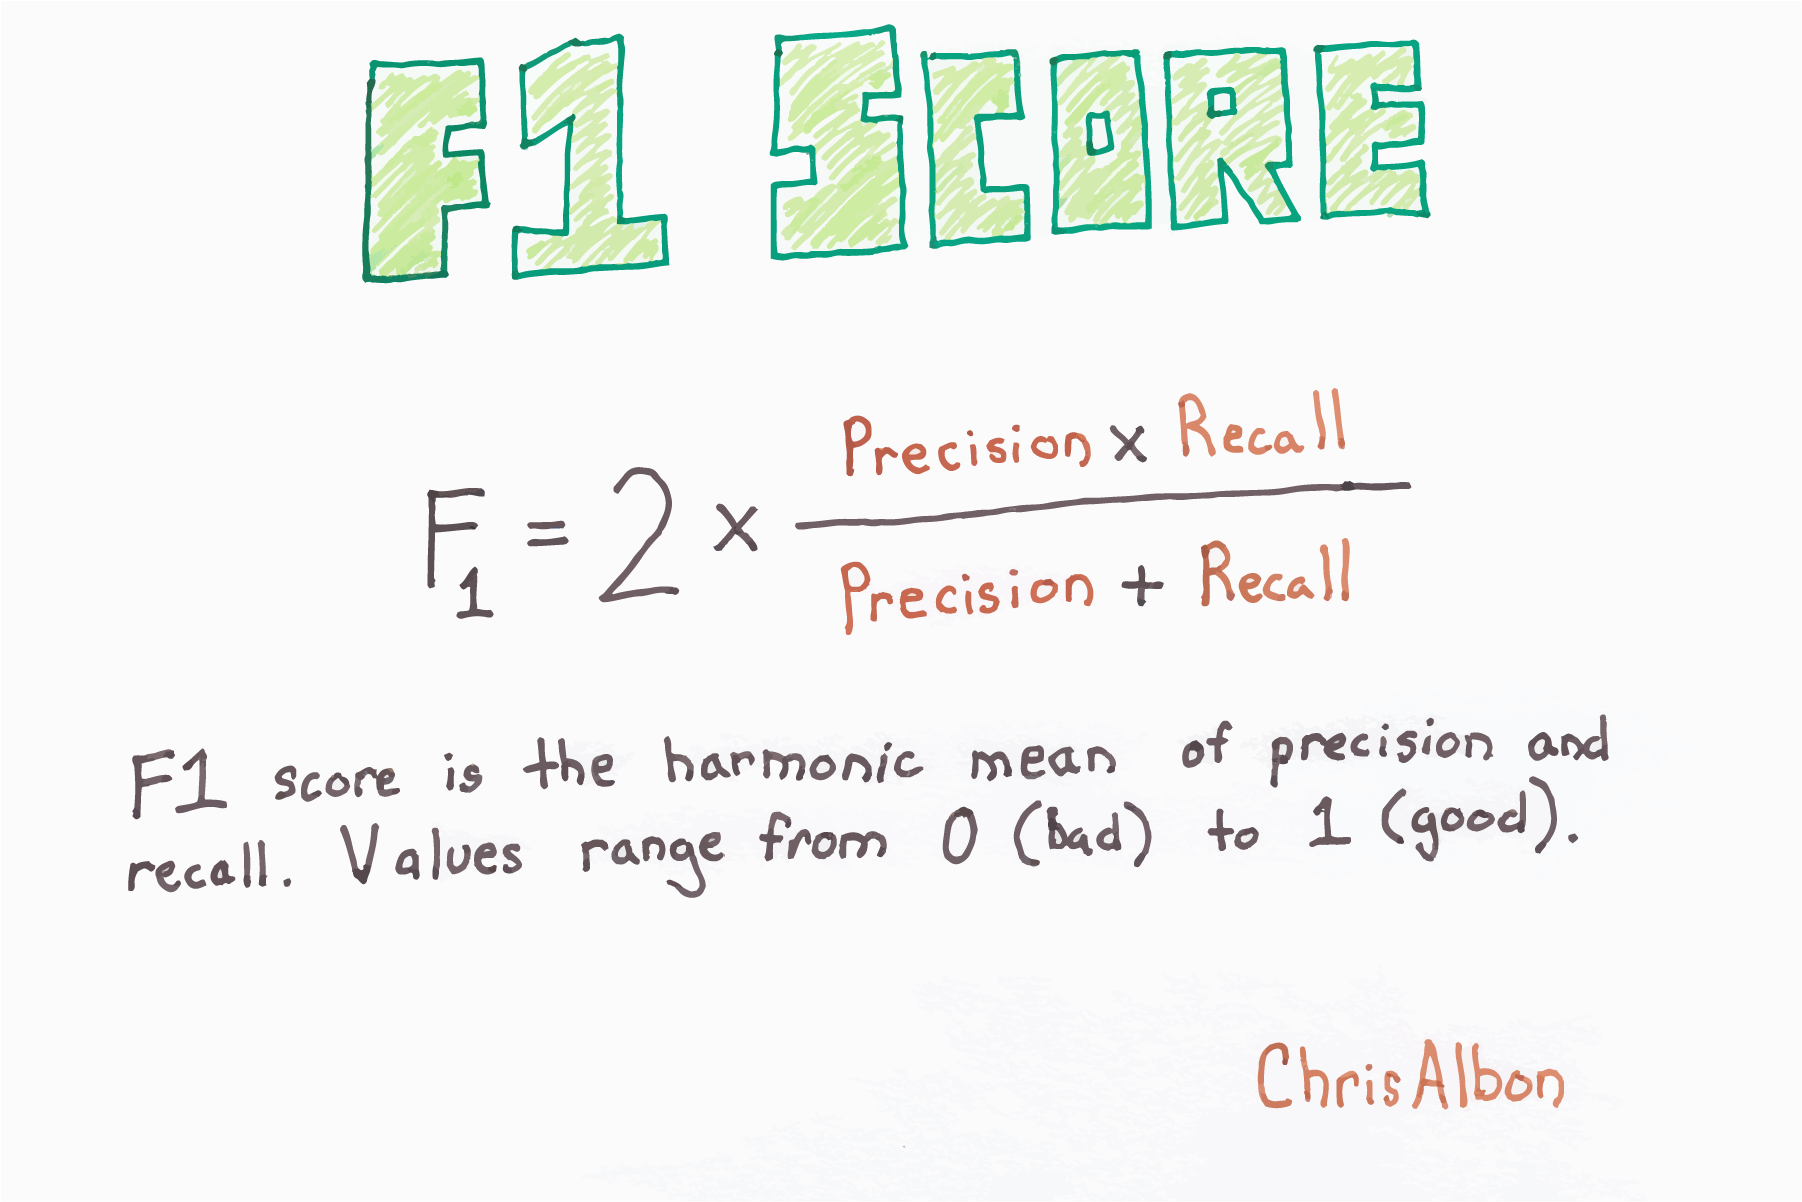

<font size="+2" color="maroon"><b>Loading & Describing the Dataset</b></font><br>

In [ ]:
# Import data
train_csv = pd.read_csv("../input/birdsong-recognition/train.csv")
test_csv = pd.read_csv("../input/birdsong-recognition/test.csv")

train_csv.head()
test_csv.head()

print("There are {} rows and {} columns in train file".format(train_csv.shape[0],train_csv.shape[1]))
print("There are {} rows and {} columns in test file".format(test_csv.shape[0],test_csv.shape[1]))


> ## CONCLUSION : There are total 21375 entries and 35 features in the dataset. Not all of them are useful. We will be using only few of them in our data analysis process.

<font size="+2" color="red"><b>EDA</b></font><br>

> Exploratory Data Analysis refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations.

*It is a good practice to understand the data first and try to gather as many insights from it. EDA is all about making sense of data in hand,before getting them dirty with it.*

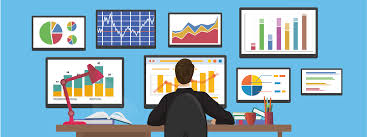

<font size="+2" color="purple"><b>Missing Values Check</b></font><br>

In [ ]:
print(train_csv.shape[0])
print(train_csv.info())

> ## CONCLUSION : As shown above, 21375 entries seems to be available for almost every feature. 

*What if a large number of rows contain missing values? - In that case we cannot simply delete the missing rows because that will cause loss of data which was present in some other non-missing columns.In this case we would have to think about replacing those missing values with some appropriate values derived after observing the behviour of dataset.*

<font size="+2" color="orange"><b>How many different birds are there in the dataset</b></font><br>

In [ ]:
print("There are {:,} unique bird species in the dataset.".format(len(train_csv['species'].unique())))

<font size="+2" color="navy"><b>When were these recordings made </b></font><br>

In [ ]:
train_csv['year'] = train_csv['date'].apply(lambda x: x.split('-')[0])
plt.figure(figsize=(16, 6))
ax = sns.countplot(train_csv['year'], palette="RdYlGn")

plt.title("Year of recording", fontsize=16)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Count", fontsize=14)
plt.xlabel("");

> ## CONCLUSION : Looks like most of the recordings were done after year 2012

<font size="+2" color="gray"><b>Elevation of Birds</b></font><br>

In [ ]:
# Top 20 most common elevations
top_20 = list(train_csv['elevation'].value_counts().head(20).reset_index()['index'])
data = train_csv[train_csv['elevation'].isin(top_20)]

plt.figure(figsize=(16, 6))
ax = sns.countplot(data['elevation'], palette="RdYlGn", order = data['elevation'].value_counts().index)


plt.title("Top 20 Elevation Types", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

> ## CONCLUSION : As shown above most of the birds were seen at an altitude of 0-10m. But few high altitude living birds can also be seen in the above graph.

<font size="+2" color="coral"><b>How many birds were heard as well as seen </b></font><br>

In [ ]:
# Create data
data = train_csv['bird_seen'].value_counts().reset_index()


plt.figure(figsize=(16, 6))
ax = sns.barplot(x = 'bird_seen', y = 'index', data = data, palette="RdYlGn")


plt.title("Song was Heard, but was Bird Seen?", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

> ## CONCLUSION : Seems like most of them are seen while recording. This could be because most of the recorded birds lived in low altitude places.

<font size="+2" color="green"><b>Country wise bird population</b></font><br>

In [ ]:
# Top 20 most common elevations
top_20 = list(train_csv['country'].value_counts().head(20).reset_index()['index'])
data = train_csv[train_csv['country'].isin(top_20)]


plt.figure(figsize=(16, 6))
ax = sns.countplot(data['country'], palette='RdYlGn', order = data['country'].value_counts().index)


plt.title("Top 20 Countries with most Recordings", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

> ## CONCLUSION : Seems like most of the recording were made at US only.

<font size="+2" color="red"><b>Lets see how long are the recordings</b></font><br>

In [ ]:
# Creating Interval for *duration* variable
train_csv['duration_interval'] = ">500"
train_csv.loc[train_csv['duration'] <= 100, 'duration_interval'] = "<=100"
train_csv.loc[(train_csv['duration'] > 100) & (train_csv['duration'] <= 200), 'duration_interval'] = "100-200"
train_csv.loc[(train_csv['duration'] > 200) & (train_csv['duration'] <= 300), 'duration_interval'] = "200-300"
train_csv.loc[(train_csv['duration'] > 300) & (train_csv['duration'] <= 400), 'duration_interval'] = "300-400"
train_csv.loc[(train_csv['duration'] > 400) & (train_csv['duration'] <= 500), 'duration_interval'] = "400-500"


plt.figure(figsize=(16, 6))
ax = sns.countplot(train_csv['duration_interval'], palette="RdYlGn")

plt.title("Distribution of Recordings Duration", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

> ## CONCLUSION : As depicted above, most of the recordings are less than 100 minutes.The site3 recordings could be in the longer ranges.

<font size="+2" color="blue"><b>Lets look at individual species count</b></font><br>

In [ ]:
print(train_csv['species'].value_counts())

train_csv['species'].value_counts().iplot()

> ## CONCLUSION: As you can see the maximum recordings available per species is limited to 100 only.

<font size="+2" color="indigo"><b>How many people recorded these audio files</b></font><br>

In [ ]:
from plotly.offline import iplot
# Total number of people who provided the recordings
print(train_csv['recordist'].nunique())


In [ ]:
# Top 10 recordists in terms of the number of recordings done
train_csv['recordist'].value_counts()[:10].sort_values().iplot(kind='barh',color='#3780BF')

<font size="+2" color="teal"><b>How many recording formats are there</b></font><br>

In [ ]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(train_csv['file_type'], palette = "RdYlGn", order = train_csv['file_type'].value_counts().index)


plt.title("Recording File Types", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

In [ ]:
train_csv['file_type'].value_counts()

> ## CONCLUSION : Most of the recordings are in mp3 playback format. The exact count is shown above.

<font size="+2" color="blue"><b>Let's listen to some of the recordings</b></font><br>

In [ ]:
# Create Full Path so we can access data more easily
base_dir = '../input/birdsong-recognition/train_audio/'
train_csv['full_path'] = base_dir + train_csv['ebird_code'] + '/' + train_csv['filename']

# Now let's sample a fiew audio files
amered = train_csv[train_csv['ebird_code'] == "amered"].sample(1, random_state = 33)['full_path'].values[0]
cangoo = train_csv[train_csv['ebird_code'] == "cangoo"].sample(1, random_state = 33)['full_path'].values[0]
haiwoo = train_csv[train_csv['ebird_code'] == "haiwoo"].sample(1, random_state = 33)['full_path'].values[0]
pingro = train_csv[train_csv['ebird_code'] == "pingro"].sample(1, random_state = 33)['full_path'].values[0]
vesspa = train_csv[train_csv['ebird_code'] == "vesspa"].sample(1, random_state = 33)['full_path'].values[0]

bird_sample_list = ["amered", "cangoo", "haiwoo", "pingro", "vesspa"]

In [ ]:
# Amered
ipd.Audio(amered)

In [ ]:
# Cangoo
ipd.Audio(cangoo)

In [ ]:
# Haiwoo
ipd.Audio(haiwoo)

In [ ]:
# Pingro
ipd.Audio(pingro)

<font size="+2" color="lime"><b>Additional Data Available</b></font><br>

## The data provided by Kaggle is limited to only 100 recordings per species. Usage of external dataset is allowed in this competition & Rohan Rao has prepared a nice dataset for this. Link to his datasets:

http://www.kaggle.com/rohanrao/xeno-canto-bird-recordings-extended-a-m

http://www.kaggle.com/rohanrao/xeno-canto-bird-recordings-extended-n-z

In [ ]:
TRAIN_EXT_PATH = "../input/xeno-canto-bird-recordings-extended-a-m/train_extended.csv"
train_ext = pd.read_csv(TRAIN_EXT_PATH)
train_ext.head()

In [ ]:
len(train_ext['ebird_code'].value_counts())

> ## CONCLUSION : The number is close to the number of unique birds in the original dataset.Original dataset has 264 bird species.

In [ ]:
len(train_ext)

> ## CONCLUSION : The original dataset has 21,375 recordings and the additional dataset provided 23,379 recordings.  

*Merging both the datasets*

In [ ]:
df_original = train_csv.groupby("species")["filename"].count().reset_index().rename(columns = {"filename": "original_recordings"})
df_extended = train_ext.groupby("species")["filename"].count().reset_index().rename(columns = {"filename": "extended_recordings"})

df = df_original.merge(df_extended, on = "species", how = "left").fillna(0)
df["total_recordings"] = df.original_recordings + df.extended_recordings
df = df.sort_values("total_recordings").reset_index().sort_values('total_recordings',ascending=False)
df.head()

In [ ]:
# Plot the total recordings
f, ax = plt.subplots(figsize=(10, 50))

sns.set_color_codes("pastel")
sns.barplot(x="total_recordings", y="species", data=df,
            label="total_recordings", color="r")

# Plot the original recordings
sns.set_color_codes("muted")
sns.barplot(x="original_recordings", y="species", data=df,
            label="original_recordings", color="g")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 2000), ylabel="",
       xlabel="Count")
sns.despine(left=True, bottom=True)

> ## CONCLUSION : Whereas the max recording available per species in the original dataset was limited to 100, there are lots of recordings available in the additional dataset.Definitely using this dataset along with the original one while training will have more promising results.  

# ✔️PLEASE GIVE THIS NOTEBOOK AN UPVOTE IF YOU LIKED IT!!!